# EXPLORATION_SBA 4.  뉴스기사 크롤링 및 분류

네이버 뉴스 크롤링해서, 뉴스 분야 예측하기
---

# Import Library (step.01)

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows=150
%matplotlib inline
import os
import glob

# NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# crawling
from konlpy.tag import Mecab
import requests
import pandas as pd
from bs4 import BeautifulSoup

# Crawling Data

In [ ]:
from newspaper import Article

#- 파싱할 뉴스 기사 주소입니다.
url = 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002881076'

#- 언어가 한국어이므로 language='ko'로 설정해줍니다.
article = Article(url, language='ko')
article.download()
article.parse()

In [3]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
    urllist= []
    for i in range(1, page_num + 1):
        url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
        news = requests.get(url, headers=headers)

        # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
        soup = BeautifulSoup(news.content, 'html.parser')

        # CASE 1
        news_list = soup.select('.newsflash_body .type06_headline li dl')
        # CASE 2
        news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
    return urllist

In [ ]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
    text_list = []
    for url in urllist:
        article = Article(url, language='ko')
        article.download()
        article.parse()
        text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
    df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
    df['code'] = idx2word[str(code)]
    return df

In [4]:
code_list = [101,102, 103, 105]

def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
        df = pd.concat([df, df_temp])
    else:
        df = df_temp

    return df

In [5]:
# df = make_total_data(1, code_list, 20200506)

# csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
# df.to_csv(csv_path, index=False)

# if os.path.exists(csv_path):
#     print('{} File Saved!'.format(csv_path))

# Load Data (step.02)

In [2]:
path = os.getenv("HOME") + "/aiffel/news_crawler/"
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))))
print(df.shape)
df.head()

(17051, 2)


,news,code
0,LG전자는 14일 밤 온라인 행사를 통해 회전형 듀얼스크린이 적용된 하반기 전략폰 ...,경제
1,[서울=뉴시스]이재준 기자 = 미국 뉴욕 증시는 14일 대형 인수합병(M&A) 소식...,경제
2,신고리원전 3·4호기 전경. 부산일보DB\n\n더불어민주당 양이원영 국회의원은 14...,경제
3,사회적 약자를 위한 따뜻한 R＆D 로봇분야 대국민 아이디어 공모전 개최 안내. KE...,경제
4,경북 포항시가 잇따른 태풍으로 피해를 본 과수농가를 돕기 위해 대구경북능금농협과 함...,경제


# Data Processing (step.02)

In [3]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       전자는 일 밤 온라인 행사를 통해 회전형 듀얼스크린이 적용된 하반기 전략폰 윙을 공...
1       서울뉴시스이재준 기자  미국 뉴욕 증시는 일 대형 인수합병 소식이 연달아 들어오면서...
2       신고리원전 호기 전경 부산일보더불어민주당 양이원영 국회의원은 일 원자력발전소와 인근...
3       사회적 약자를 위한 따뜻한  로봇분야 대국민 아이디어 공모전 개최 안내  제공한국산...
4       경북 포항시가 잇따른 태풍으로 피해를 본 과수농가를 돕기 위해 대구경북능금농협과 함...
                              ...                        
1595    한국콘텐츠진흥원의 지능형 콘텐츠 창작도구 개발 과제 개요 한국콘텐츠진흥원의 지능형 ...
1596    서울 강서구 마곡 사이언스파크 전경   제공 서울 강서구 마곡 사이언스파크 전경  ...
1597    디지털데일리 이안나기자 대형 디스플레이와 부드러워진 펜이 소비자들에게 통한 것일까 ...
1598    박영선 중기부 장관앞줄 왼쪽 세 번째이 일 서울 강남에서 열린 글로벌창업사관학교 강...
1599    강덕영 한국유나이티드제약 대표한국유나이티드제약 제공 강덕영 한국유나이티드제약 대표한...
Name: news, Length: 17051, dtype: object

In [4]:
# Null 값을 확인합니다.
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [5]:
# 중복된 데이터를 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  14105


In [6]:
# 불용어 제거
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [7]:
# 토큰화 및 토큰화 과정에서 불용어 제거
from konlpy.tag import Mecab
tokenizer = Mecab()

def preprocessing(data):
    text_data = []

    for sentence in data:
        temp_data = []
        #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
        #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

    text_data = list(map(' '.join, text_data))

    return text_data

text_data = preprocessing(df['news'])

In [8]:
text_data = preprocessing(df['news'])
print(text_data[0])

전자 일 밤 온라인 행사 를 통해 회전 형 듀얼 스크린 적용 된 하반기 전략 폰 윙 공개 사진 동영상 캡쳐 윙 스 위 블 회전 모드 에서 멀티 태 스 킹 사용 경험 제공 한다 내비게이션 화면 방해 받 지 않 고 전화 를 받 거나 동영상 시청 면서 웹 서핑 사진 전자 스마트폰 최초 로 짐벌 기능 탑재 고 기존 폰 에서 호평 받 았 던 동영상 촬영 기능 도 그대로 적용 해 동영상 콘텐츠 제작 최적 화 됐 다는 평가 사진 전자 데일리 장영 전자 이전 없 던 새로운 형태 스마트폰 고 나왔 회전 형 디스플레이 를 적용 하반기 전략 폰 윙 그 주인공 다일 밤 시 부터 시작 된 온라인 공개 행사 에서 실물 드러낸 윙 대해 소비자 사이 에서 우려 와 비판 도 지만 새로운 사용 성 혁신 성 대한 기대감 도 높 았 윙 존재 알려 지 면서 기대감 보다 논란 컸 던 제품 과거 삼성전자 애니콜 모델 중 하나 인 가로본능 폰 연상 시켜 구시대 적 라는 비판 내구 성 무게 중심 두께 대한 우려 컸 삼성전자 와 화웨이 경쟁사 폼 팩터 기기 형태 혁신 으로 폴 더블 접히 폰 택한 것 달리 듀얼 스크린 돌리 낯선 방식 택한 점 도 의구심 자아냈 다홍 신 태 전자 사업 본부 책임 고객 이미 익숙 해진 습관 바꾸 지 않 으면서 도 멀티 스크린 사용 방법 대해 고민 많이 다며 스 위 블 회전 형 듀얼 스크린 개발 배경 설명 메인 스크린 회전 시킨 상태 를 스 위 블 모드 라고 평상시 기존 바 형태 스마트폰 처럼 사용 다가 필요 때 만 스 위 블 모드 로 바꾸 면 된다는 것 특히 스 위 블 모드 에서 두 개 화면 이용 해 하나 어플리케이션 앱 사용 도 고 각 화면 다른 앱 띄울 도 어 사용 자 원 대로 직관 적 인 사용 가능 다는 것 장점 이날 온라인 행사 에서 유명 유 튜버 직접 윙 사용 경험 소개 며 멀티 태 스 킹 윙 만 강점 부각 시켰 유 튜버 영국 남자 메인 스크린 돌리 면 나타나 보조 스크린 정말 멋지 라며 예 를 어 아무런 방해 없이 전체 화면 으로 영상 시청 면서 동시 알림 확인 다고

# EDA (step.03)

<AxesSubplot:>

/home/theo/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/theo/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/theo/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/theo/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/theo/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/theo/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: Runtim

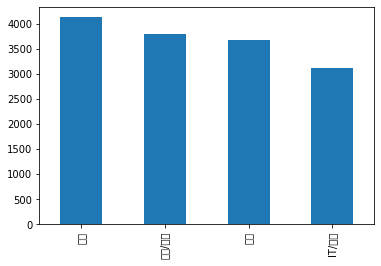

In [13]:
# 카테고리별 샘플 분포 확인
df['code'].value_counts().plot(kind = 'bar')

In [14]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학   3121
1     경제   4125
2     사회   3678
3  생활/문화   3797


# Build NLP Classification Model (step.04)

### 훈련 데이터와 테스트 데이터를 분리 (step. 4-1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [16]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 11040
테스트용 뉴스 기사의 개수 :  3681
훈련용 레이블의 개수 :  11040
테스트용 레이블의 개수 :  3681


### TF-IDF 벡터로 변환 (step. 4-2)

In [17]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
# test
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

In [19]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['경제']


In [21]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.86      0.70      0.77       803
          경제       0.65      0.81      0.72      1050
          사회       0.74      0.79      0.76       916
       생활/문화       0.80      0.65      0.72       912

    accuracy                           0.74      3681
   macro avg       0.76      0.74      0.74      3681
weighted avg       0.75      0.74      0.74      3681



# Build AUTO_NEWS_CRAWLER
### (뉴스 데이터 크롤링 & 카테고리 자동 분류 & 모델별 정확도 구현)

##### 기능 정의
1. 날짜와 분야를 입력하면 해당하는 뉴스를 크롤링하여 csv 파일로 저장
2. 크롤링한 뉴스 데이터에서 한글 외 문자 삭제 기능 on/off
3. 크롤링한 뉴스 데이터에서 중복 데이터 삭제 기능 on/off
4. 불용어 대상 리스트 추가, 삭제 -> 클래스 개념 추가 공부하여 업데이트 필요
5. 형태소 분류기 모델별 토큰화 -> .self 로 진행할 경우 커널이 죽는 현상 해결 필요
6. 형태소 분류기 모델별 TF-IDF 벡터 변환 -> 형태소 분류 모델 추가 위해 자바 설치 필요
7. 형태소 분류기 모델별 분석 보고서 출력

In [45]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows=150
%matplotlib inline
import os
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# crawling
from konlpy.tag import Mecab
import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article

# tokenizer
from konlpy.tag import Hannanum
from konlpy.tag import Mecab
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Okt


class AUTONC:
    
    def __init__(self, drop_non_kor = 'off', drop_duplicates = 'off'):
        
        # 저장한 뉴스 데이터를 DataFrame 으로 가져옵니다.
        path = os.getenv("HOME") + "/aiffel/news_crawler/"
        self.df = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))))
        
        # 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
        # 해당 기능이 'on'이 된 경우에만 작동합니다.
        if drop_non_kor == 'on':
            self.df['news'] = self.df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
            print('한글 외 문자 제거 완료: ', self.df['news'].head(), sep = '\n')
            
        # 중복된 데이터를 제거합니다.
        if drop_duplicates == 'on':         
            self.df.drop_duplicates(subset=['news'], inplace=True)
            print('중복 제거된 뉴스 기사의 개수:',len(self.df), sep = '\n')
                      
            
    def crawling(self, page_num = 1, code='경제', date = 20201123):
        
        # 날짜
        self.date = date
        
        # 네이버 뉴스 페이지 코드
        code_list = {
            '정치':100,
            '경제':101,
            '사회':102,
            '생활문화':103,
            '세계': 104,
            'IT과학':105
                    }
        self.code = code_list[code]
        
        # url 리스트 생성하기
        urllist= []
        for i in range(1, page_num + 1):
            url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(self.code)+'&date='+str(self.date)+'&page='+str(i)
            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
            news = requests.get(url, headers=headers)

            # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
            soup = BeautifulSoup(news.content, 'html.parser')

            # CASE 1
            news_list = soup.select('.newsflash_body .type06_headline li dl')
            # CASE 2
            news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
        # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
        for line in news_list:
            urllist.append(line.a.get('href'))
            
        # url 리스트에서 뉴스 텍스트 가져오기
        text_list = []
        for url in urllist:
            article = Article(url, language='ko')
            article.download()
            article.parse()
            text_list.append(article.text)
        
        idx2word = {'100' : '정치' ,'101' : '경제', '102' : '사회', '103' : '생활/문화', '104' : '세계','105' : 'IT/과학'}
        
        data = pd.DataFrame({'news': text_list})
        data['code'] = idx2word[str(self.code)]
        
        csv_path = os.getenv("HOME") + "/aiffel/news_crawler/" + str(self.date) + '_' +str(self.code) + '_news_data.csv'
        data.to_csv(csv_path, index=False)

        if os.path.exists(csv_path):
            print('{} File Saved!'.format(csv_path))
    

           
    def fit(self):
        
        # tokenizer 함수에서 저장한 text data를 전역변수로 설정합니다.
        global text_data
        self.text_data = text_data
        
        # train, test data 분류
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.text_data, self.df['code'], 
                                                                                test_size=0.3, 
                                                                                random_state = 91)
        #TF-IDF 벡터로 변환
        #- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
        count_vect = CountVectorizer()
        self.X_train_counts = count_vect.fit_transform(self.X_train)

        #- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
        tfidf_transformer = TfidfTransformer()
        self.X_train_tfidf = tfidf_transformer.fit_transform(self.X_train_counts)

        #- 나이브 베이즈 분류기를 수행합니다.
        #- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
        self.clf = MultinomialNB().fit(self.X_train_tfidf, self.y_train)
        
        self.data_tfidf = tfidf_transformer.transform(count_vect.transform(self.X_test))
        
          
    def predict(self):
        y_pred = self.clf.predict(self.data_tfidf)
        self.results = {
                'accuracy_score': accuracy_score(self.y_test, y_pred),
                'classification_report': classification_report(self.y_test, y_pred),
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }          

    def show(self, insight='classification_report'):
        
        if insight == 'confusion_matrix':
            sns.heatmap(self.results[insight], annot=True)
            plt.show()

        else:
            print(self.results[insight])            
            
    def print_df(self):
        return self.df

In [46]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']


def tokenizer(data, name = 'Mecab'):
    
         # 토큰화 모델
    models = {
        'Mecab': Mecab,
        'Okt': Okt,
        'Hannanum': Hannanum,
        'Kkma': Kkma,
        'Komoran': Komoran
    }
    
    tokenizer = models[name]()
    
    text_data = []

    for sentence in data:
        temp_data = []
        #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
        #- 불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords] 
        text_data.append(temp_data)

    text_data = list(map(' '.join, text_data))

    return text_data

# test

In [47]:
# 오토 크롤러 & 분석기 객체 만들기
auto = AUTONC(drop_non_kor = 'on', drop_duplicates = 'on')

한글 외 문자 제거 완료: 
0    전자는 일 밤 온라인 행사를 통해 회전형 듀얼스크린이 적용된 하반기 전략폰 윙을 공...
1    서울뉴시스이재준 기자  미국 뉴욕 증시는 일 대형 인수합병 소식이 연달아 들어오면서...
2    신고리원전 호기 전경 부산일보더불어민주당 양이원영 국회의원은 일 원자력발전소와 인근...
3    사회적 약자를 위한 따뜻한  로봇분야 대국민 아이디어 공모전 개최 안내  제공한국산...
4    경북 포항시가 잇따른 태풍으로 피해를 본 과수농가를 돕기 위해 대구경북능금농협과 함...
Name: news, dtype: object
중복 제거된 뉴스 기사의 개수:
14094


In [50]:
# 토큰화 & 불용어 제거
text_data = tokenizer(auto.print_df()['news'], name = 'Okt')

In [51]:
# 모델 학습 & 분류
auto.fit()
auto.predict()

/home/theo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


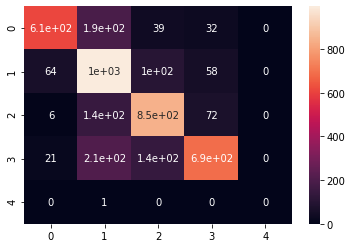

In [52]:
# 분류 결과 확인
auto.show(insight='confusion_matrix')

In [53]:
# 분류 결과 확인
auto.show(insight = 'classification_report')

              precision    recall  f1-score   support

       IT/과학       0.87      0.70      0.78       873
          경제       0.65      0.82      0.72      1222
          사회       0.75      0.79      0.77      1070
       생활/문화       0.81      0.65      0.72      1063
          정치       0.00      0.00      0.00         1

    accuracy                           0.74      4229
   macro avg       0.61      0.59      0.60      4229
weighted avg       0.76      0.74      0.74      4229



In [54]:
# 추가로 뉴스 기사를 더 모아봅시다!

In [55]:
auto.crawling(code='정치', date = 20201127)

/home/theo/aiffel/news_crawler/20201127_100_news_data.csv File Saved!
